# Analyze multitimescale RNN

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/pirnns/pirnns
Directory added to path:  /home/facosta/pirnns
Directory added to path:  /home/facosta/pirnns/pirnns


## Load the trained model

In [3]:
import torch
import yaml

from pirnns.rnns.multitimescale_rnn import MultiTimescaleRNN, MultiTimescaleRNNLightning

import torch.nn as nn

import glob

model_type = "multitimescale"
run_id = "20250908_093546"

run_dir = f"logs/checkpoints/{model_type}_{run_id}"
config_path = f"{run_dir}/config_{run_id}.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

checkpoint_files = glob.glob(f"{run_dir}/best-model-*.ckpt")
print(f"Loading Lightning checkpoint from: {checkpoint_files[0]}")

model = MultiTimescaleRNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["num_place_cells"],
    dt=config["dt"],
    timescales_config=config["timescales_config"],
    activation=getattr(nn, config["activation"]),
)

model_lightning = MultiTimescaleRNNLightning.load_from_checkpoint(
    checkpoint_files[0],
    model=model,
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"],
    step_size=config["step_size"],
    gamma=config["gamma"],
)

model = model_lightning.model

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.eval()

print(f"Loaded model from run: {run_id}")
print(f"Model config: {config_path}")
print(f"Device: {device}")

Loading Lightning checkpoint from: logs/checkpoints/multitimescale_20250908_093546/best-model-epoch=96-val_loss=6.039.ckpt
Loaded model from run: 20250908_093546
Model config: logs/checkpoints/multitimescale_20250908_093546/config_20250908_093546.yaml
Device: cuda


## Inspect recurrent weights

In [7]:
model.rnn_step.W_rec.weight.shape

torch.Size([4096, 4096])

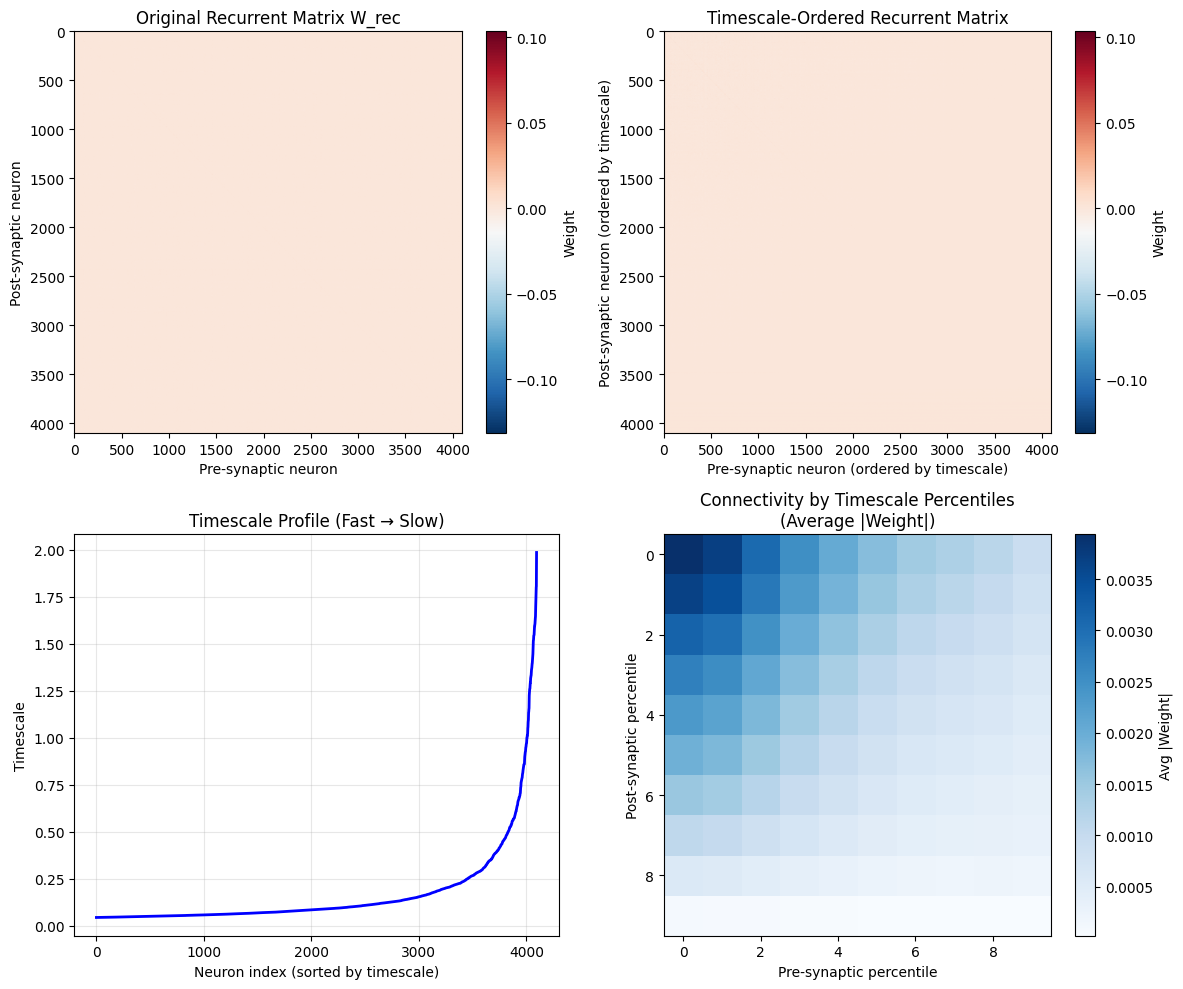

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def visualize_timescale_ordered_connectivity(model, figsize=(12, 10)):
    """
    Visualize the recurrent connectivity matrix ordered by timescales.
    """
    # Get the recurrent weight matrix and timescales
    W_rec = (
        model.rnn_step.W_rec.weight.detach().cpu().numpy()
    )  # Shape: (hidden_size, hidden_size)
    timescales = model.rnn_step.timescales.cpu().numpy()
    alphas = model.rnn_step.alphas.cpu().numpy()

    # Get the order indices (sort by timescale)
    timescale_order = np.argsort(timescales)  # Fast to slow

    # Reorder the weight matrix
    W_rec_ordered = W_rec[timescale_order, :][:, timescale_order]
    ordered_timescales = timescales[timescale_order]
    ordered_alphas = alphas[timescale_order]

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # === ORIGINAL WEIGHT MATRIX ===
    im1 = axes[0, 0].imshow(W_rec, cmap="RdBu_r", aspect="auto")
    axes[0, 0].set_title("Original Recurrent Matrix W_rec")
    axes[0, 0].set_xlabel("Pre-synaptic neuron")
    axes[0, 0].set_ylabel("Post-synaptic neuron")
    plt.colorbar(im1, ax=axes[0, 0], label="Weight")

    # === TIMESCALE-ORDERED WEIGHT MATRIX ===
    im2 = axes[0, 1].imshow(W_rec_ordered, cmap="RdBu_r", aspect="auto")
    axes[0, 1].set_title("Timescale-Ordered Recurrent Matrix")
    axes[0, 1].set_xlabel("Pre-synaptic neuron (ordered by timescale)")
    axes[0, 1].set_ylabel("Post-synaptic neuron (ordered by timescale)")
    plt.colorbar(im2, ax=axes[0, 1], label="Weight")

    # Add timescale annotations
    n_units = len(ordered_timescales)
    if n_units <= 50:  # Only add ticks if not too many units
        axes[0, 1].set_xticks(range(0, n_units, max(1, n_units // 10)))
        axes[0, 1].set_yticks(range(0, n_units, max(1, n_units // 10)))

    # === TIMESCALE PROFILE ===
    axes[1, 0].plot(
        range(len(ordered_timescales)), ordered_timescales, "b-", linewidth=2
    )
    axes[1, 0].set_xlabel("Neuron index (sorted by timescale)")
    axes[1, 0].set_ylabel("Timescale")
    axes[1, 0].set_title("Timescale Profile (Fast → Slow)")
    axes[1, 0].grid(True, alpha=0.3)

    # Highlight discrete values if applicable
    unique_timescales = np.unique(ordered_timescales)
    if len(unique_timescales) <= 10:  # Discrete case
        for i, ts in enumerate(unique_timescales):
            mask = ordered_timescales == ts
            axes[1, 0].axhline(
                ts,
                color=f"C{i}",
                linestyle="--",
                alpha=0.7,
                label=f"τ={ts:.3f} ({mask.sum()} units)",
            )
        axes[1, 0].legend()

    # === CONNECTIVITY ANALYSIS ===
    # Analyze connectivity patterns between timescale groups
    if len(unique_timescales) <= 10:  # For discrete timescales
        # Create connectivity matrix between timescale groups
        group_connectivity = np.zeros((len(unique_timescales), len(unique_timescales)))
        group_labels = []

        for i, ts_pre in enumerate(unique_timescales):
            mask_pre = ordered_timescales == ts_pre
            group_labels.append(f"τ={ts_pre:.3f}")

            for j, ts_post in enumerate(unique_timescales):
                mask_post = ordered_timescales == ts_post

                # Average connectivity from group i to group j
                submatrix = W_rec_ordered[np.ix_(mask_post, mask_pre)]
                group_connectivity[j, i] = np.mean(np.abs(submatrix))

        im4 = axes[1, 1].imshow(group_connectivity, cmap="Blues", aspect="auto")
        axes[1, 1].set_title("Inter-Group Connectivity\n(Average |Weight|)")
        axes[1, 1].set_xlabel("Pre-synaptic group")
        axes[1, 1].set_ylabel("Post-synaptic group")
        axes[1, 1].set_xticks(range(len(group_labels)))
        axes[1, 1].set_yticks(range(len(group_labels)))
        axes[1, 1].set_xticklabels(group_labels, rotation=45)
        axes[1, 1].set_yticklabels(group_labels)
        plt.colorbar(im4, ax=axes[1, 1], label="Avg |Weight|")

        # Add text annotations
        for i in range(len(unique_timescales)):
            for j in range(len(unique_timescales)):
                text = axes[1, 1].text(
                    j,
                    i,
                    f"{group_connectivity[i, j]:.3f}",
                    ha="center",
                    va="center",
                    color="black",
                    fontsize=8,
                )

    else:
        # For continuous timescales, show weight statistics by timescale percentiles
        n_bins = 10
        percentiles = np.linspace(0, 100, n_bins + 1)
        bin_edges = np.percentile(ordered_timescales, percentiles)

        connectivity_by_bin = np.zeros((n_bins, n_bins))

        for i in range(n_bins):
            mask_pre = (ordered_timescales >= bin_edges[i]) & (
                ordered_timescales < bin_edges[i + 1]
            )
            if i == n_bins - 1:  # Include the maximum value in the last bin
                mask_pre = (ordered_timescales >= bin_edges[i]) & (
                    ordered_timescales <= bin_edges[i + 1]
                )

            for j in range(n_bins):
                mask_post = (ordered_timescales >= bin_edges[j]) & (
                    ordered_timescales < bin_edges[j + 1]
                )
                if j == n_bins - 1:
                    mask_post = (ordered_timescales >= bin_edges[j]) & (
                        ordered_timescales <= bin_edges[j + 1]
                    )

                if mask_pre.sum() > 0 and mask_post.sum() > 0:
                    submatrix = W_rec_ordered[np.ix_(mask_post, mask_pre)]
                    connectivity_by_bin[j, i] = np.mean(np.abs(submatrix))

        im4 = axes[1, 1].imshow(connectivity_by_bin, cmap="Blues", aspect="auto")
        axes[1, 1].set_title(
            "Connectivity by Timescale Percentiles\n(Average |Weight|)"
        )
        axes[1, 1].set_xlabel("Pre-synaptic percentile")
        axes[1, 1].set_ylabel("Post-synaptic percentile")
        plt.colorbar(im4, ax=axes[1, 1], label="Avg |Weight|")

    plt.tight_layout()
    return fig, W_rec_ordered, timescale_order


# Usage:
fig, W_ordered, order_indices = visualize_timescale_ordered_connectivity(model)
plt.show()

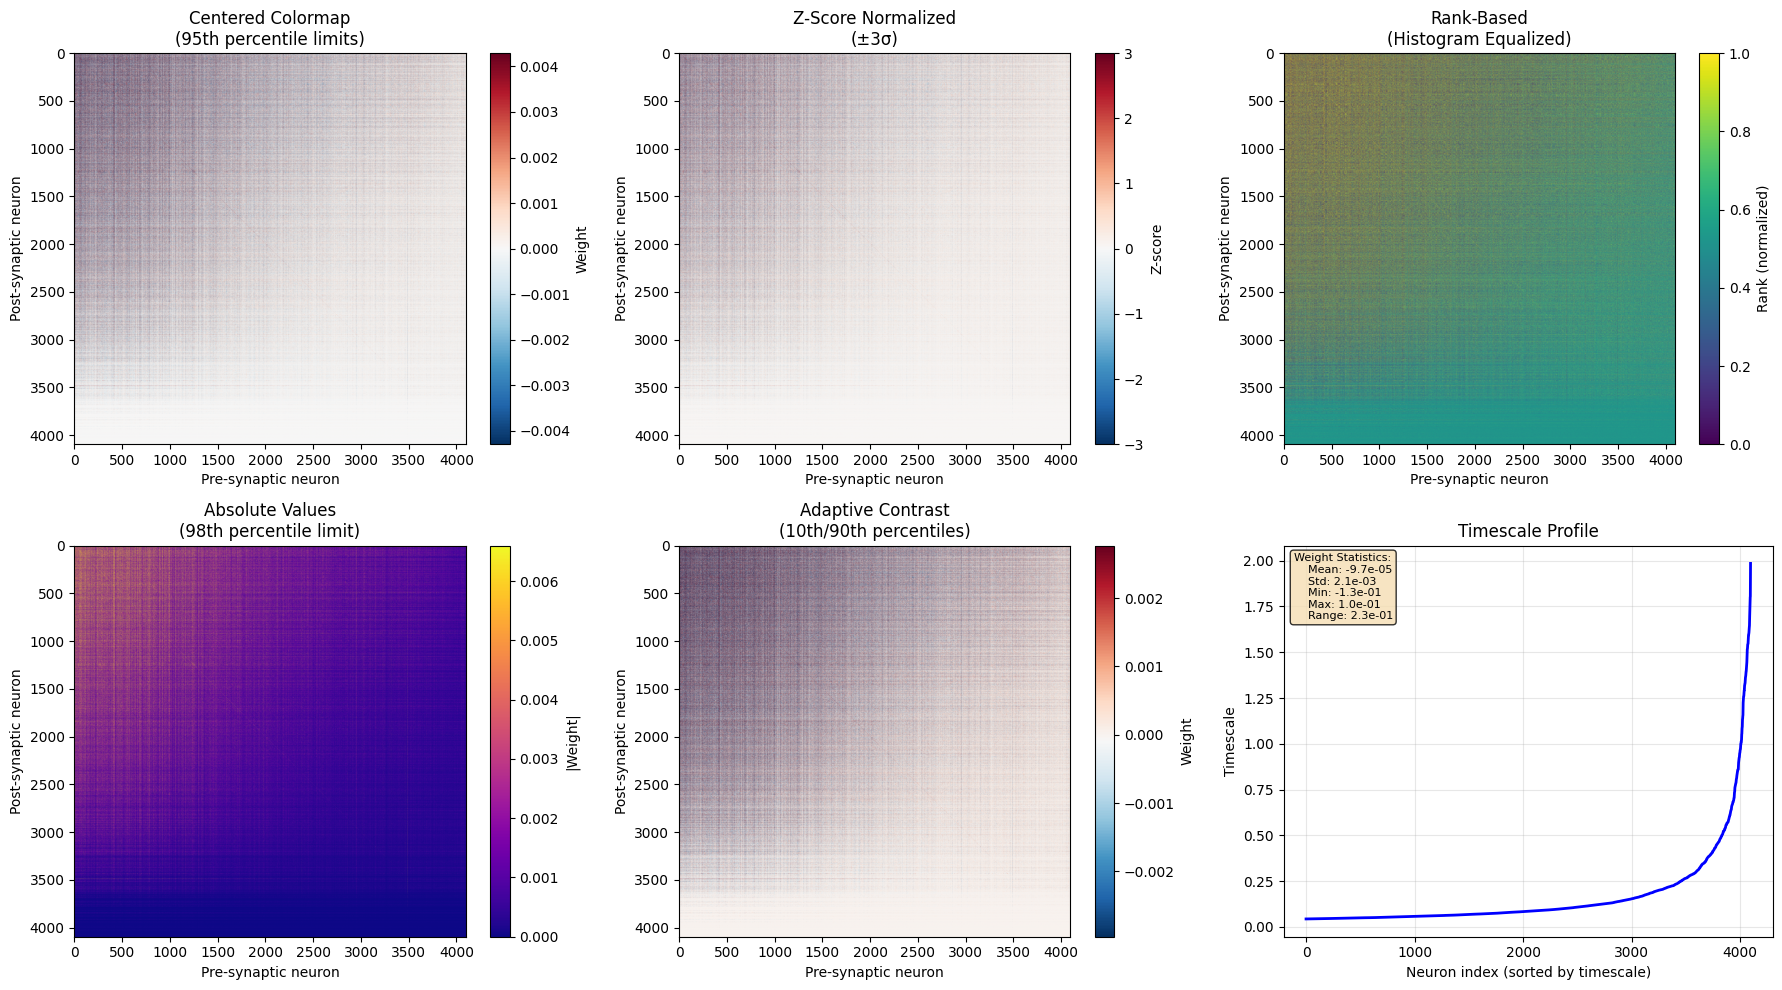

In [12]:
def visualize_timescale_ordered_connectivity(model, figsize=(12, 10)):
    """
    Visualize the recurrent connectivity matrix ordered by timescales with enhanced contrast.
    """
    # Get the recurrent weight matrix and timescales
    W_rec = model.rnn_step.W_rec.weight.detach().cpu().numpy()
    timescales = model.rnn_step.timescales.cpu().numpy()
    alphas = model.rnn_step.alphas.cpu().numpy()

    # Get the order indices (sort by timescale)
    timescale_order = np.argsort(timescales)

    # Reorder the weight matrix
    W_rec_ordered = W_rec[timescale_order, :][:, timescale_order]
    ordered_timescales = timescales[timescale_order]

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # === METHOD 1: CENTERED COLORMAP ===
    # Center the colormap around 0 and use percentile-based limits
    vmax = np.percentile(
        np.abs(W_rec_ordered), 95
    )  # Use 95th percentile to avoid outliers

    im1 = axes[0, 0].imshow(
        W_rec_ordered, cmap="RdBu_r", aspect="auto", vmin=-vmax, vmax=vmax
    )
    axes[0, 0].set_title("Centered Colormap\n(95th percentile limits)")
    axes[0, 0].set_xlabel("Pre-synaptic neuron")
    axes[0, 0].set_ylabel("Post-synaptic neuron")
    plt.colorbar(im1, ax=axes[0, 0], label="Weight")

    # === METHOD 2: Z-SCORE NORMALIZATION ===
    W_rec_zscore = (W_rec_ordered - W_rec_ordered.mean()) / W_rec_ordered.std()

    im2 = axes[0, 1].imshow(
        W_rec_zscore, cmap="RdBu_r", aspect="auto", vmin=-3, vmax=3
    )  # Clip at 3 standard deviations
    axes[0, 1].set_title("Z-Score Normalized\n(±3σ)")
    axes[0, 1].set_xlabel("Pre-synaptic neuron")
    axes[0, 1].set_ylabel("Post-synaptic neuron")
    plt.colorbar(im2, ax=axes[0, 1], label="Z-score")

    # === METHOD 3: RANK-BASED (HISTOGRAM EQUALIZATION) ===
    # This reveals structure regardless of the actual weight distribution
    W_flat = W_rec_ordered.flatten()
    W_ranks = np.argsort(np.argsort(W_flat)).reshape(W_rec_ordered.shape)
    W_rank_normalized = W_ranks / W_ranks.max()

    im3 = axes[0, 2].imshow(W_rank_normalized, cmap="viridis", aspect="auto")
    axes[0, 2].set_title("Rank-Based\n(Histogram Equalized)")
    axes[0, 2].set_xlabel("Pre-synaptic neuron")
    axes[0, 2].set_ylabel("Post-synaptic neuron")
    plt.colorbar(im3, ax=axes[0, 2], label="Rank (normalized)")

    # === METHOD 4: ABSOLUTE VALUES WITH DIVERGING COLORMAP ===
    W_abs = np.abs(W_rec_ordered)

    im4 = axes[1, 0].imshow(
        W_abs, cmap="plasma", aspect="auto", vmin=0, vmax=np.percentile(W_abs, 98)
    )
    axes[1, 0].set_title("Absolute Values\n(98th percentile limit)")
    axes[1, 0].set_xlabel("Pre-synaptic neuron")
    axes[1, 0].set_ylabel("Post-synaptic neuron")
    plt.colorbar(im4, ax=axes[1, 0], label="|Weight|")

    # === METHOD 5: ADAPTIVE CONTRAST ===
    # Use different percentiles for positive and negative weights
    pos_weights = W_rec_ordered[W_rec_ordered > 0]
    neg_weights = W_rec_ordered[W_rec_ordered < 0]

    if len(pos_weights) > 0 and len(neg_weights) > 0:
        vmax_adaptive = np.percentile(pos_weights, 90)
        vmin_adaptive = np.percentile(neg_weights, 10)
    else:
        vmax_adaptive = np.percentile(np.abs(W_rec_ordered), 90)
        vmin_adaptive = -vmax_adaptive

    im5 = axes[1, 1].imshow(
        W_rec_ordered,
        cmap="RdBu_r",
        aspect="auto",
        vmin=vmin_adaptive,
        vmax=vmax_adaptive,
    )
    axes[1, 1].set_title("Adaptive Contrast\n(10th/90th percentiles)")
    axes[1, 1].set_xlabel("Pre-synaptic neuron")
    axes[1, 1].set_ylabel("Post-synaptic neuron")
    plt.colorbar(im5, ax=axes[1, 1], label="Weight")

    # === TIMESCALE PROFILE ===
    axes[1, 2].plot(
        range(len(ordered_timescales)), ordered_timescales, "b-", linewidth=2
    )
    axes[1, 2].set_xlabel("Neuron index (sorted by timescale)")
    axes[1, 2].set_ylabel("Timescale")
    axes[1, 2].set_title("Timescale Profile")
    axes[1, 2].grid(True, alpha=0.3)

    # Add statistics
    weight_stats = f"""Weight Statistics:
    Mean: {W_rec_ordered.mean():.1e}
    Std: {W_rec_ordered.std():.1e}
    Min: {W_rec_ordered.min():.1e}
    Max: {W_rec_ordered.max():.1e}
    Range: {W_rec_ordered.max() - W_rec_ordered.min():.1e}"""

    axes[1, 2].text(
        0.02,
        0.98,
        weight_stats,
        transform=axes[1, 2].transAxes,
        verticalalignment="top",
        fontsize=8,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    plt.tight_layout()
    return fig, W_rec_ordered


# Usage:
fig, W_ordered = visualize_timescale_ordered_connectivity(model)
plt.show()

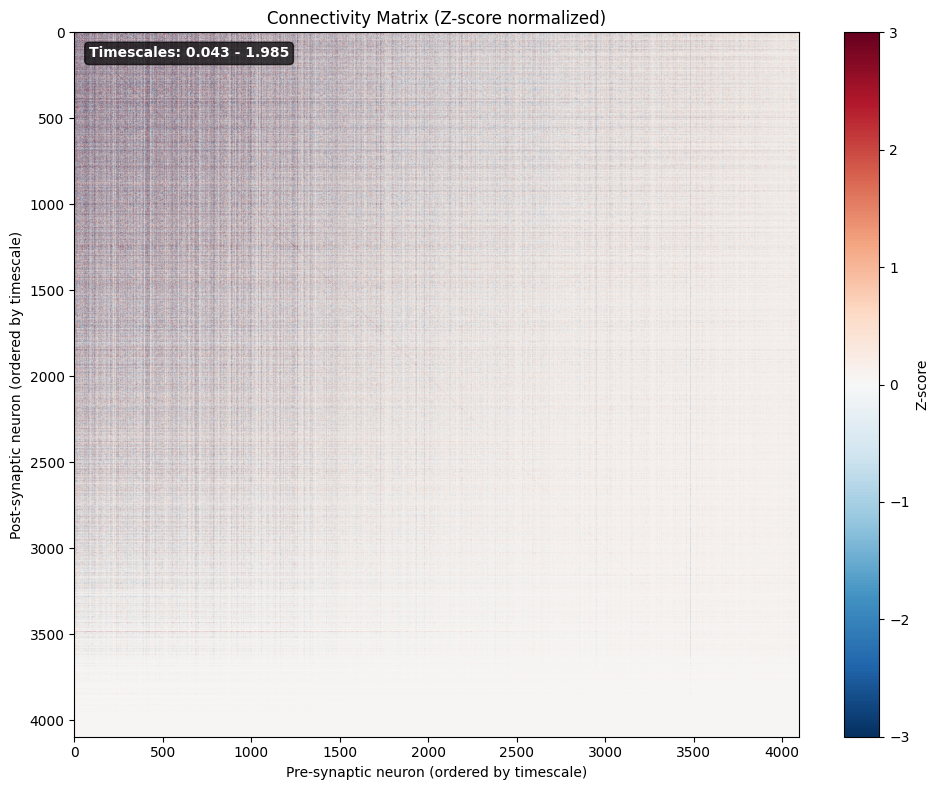

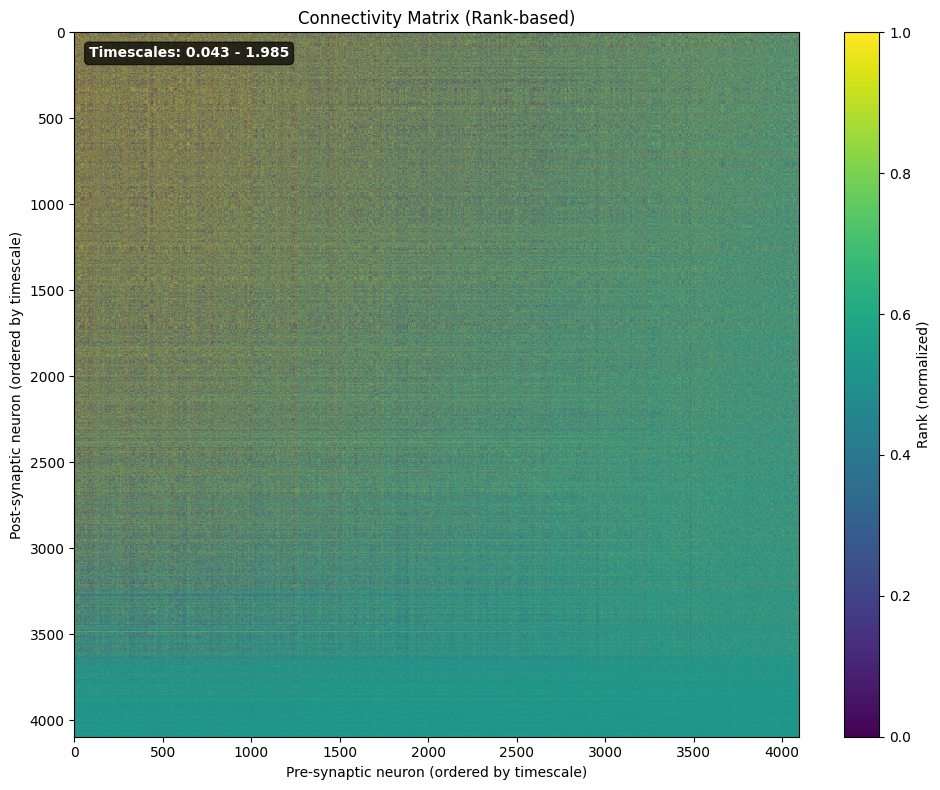

In [13]:
def enhanced_connectivity_heatmap(model, method="zscore", figsize=(10, 8)):
    """
    Create a single, enhanced connectivity heatmap.

    Methods:
    - 'zscore': Z-score normalization
    - 'percentile': Percentile-based limits
    - 'rank': Rank-based (histogram equalization)
    - 'adaptive': Adaptive contrast
    """
    W_rec = model.rnn_step.W_rec.weight.detach().cpu().numpy()
    timescales = model.rnn_step.timescales.cpu().numpy()

    # Reorder by timescale
    timescale_order = np.argsort(timescales)
    W_rec_ordered = W_rec[timescale_order, :][:, timescale_order]
    ordered_timescales = timescales[timescale_order]

    fig, ax = plt.subplots(figsize=figsize)

    if method == "zscore":
        W_plot = (W_rec_ordered - W_rec_ordered.mean()) / W_rec_ordered.std()
        im = ax.imshow(W_plot, cmap="RdBu_r", aspect="auto", vmin=-3, vmax=3)
        cbar_label = "Z-score"
        title = "Connectivity Matrix (Z-score normalized)"

    elif method == "percentile":
        vmax = np.percentile(np.abs(W_rec_ordered), 95)
        im = ax.imshow(
            W_rec_ordered, cmap="RdBu_r", aspect="auto", vmin=-vmax, vmax=vmax
        )
        cbar_label = "Weight"
        title = "Connectivity Matrix (95th percentile limits)"

    elif method == "rank":
        W_flat = W_rec_ordered.flatten()
        W_ranks = np.argsort(np.argsort(W_flat)).reshape(W_rec_ordered.shape)
        W_plot = W_ranks / W_ranks.max()
        im = ax.imshow(W_plot, cmap="viridis", aspect="auto")
        cbar_label = "Rank (normalized)"
        title = "Connectivity Matrix (Rank-based)"

    elif method == "adaptive":
        pos_weights = W_rec_ordered[W_rec_ordered > 0]
        neg_weights = W_rec_ordered[W_rec_ordered < 0]

        if len(pos_weights) > 0 and len(neg_weights) > 0:
            vmax = np.percentile(pos_weights, 85)
            vmin = np.percentile(neg_weights, 15)
        else:
            vmax = np.percentile(np.abs(W_rec_ordered), 85)
            vmin = -vmax

        im = ax.imshow(
            W_rec_ordered, cmap="RdBu_r", aspect="auto", vmin=vmin, vmax=vmax
        )
        cbar_label = "Weight"
        title = "Connectivity Matrix (Adaptive contrast)"

    # Add timescale indicators
    n_units = len(ordered_timescales)
    unique_timescales = np.unique(ordered_timescales)

    if len(unique_timescales) <= 10:  # Discrete case
        # Add lines to separate timescale groups
        boundaries = []
        for ts in unique_timescales[:-1]:  # Skip the last one
            boundary = np.where(ordered_timescales == ts)[0][-1] + 0.5
            boundaries.append(boundary)
            ax.axhline(boundary, color="white", linewidth=1, alpha=0.8)
            ax.axvline(boundary, color="white", linewidth=1, alpha=0.8)

    ax.set_xlabel("Pre-synaptic neuron (ordered by timescale)")
    ax.set_ylabel("Post-synaptic neuron (ordered by timescale)")
    ax.set_title(title)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label=cbar_label)

    # Add timescale info
    ts_info = (
        f"Timescales: {ordered_timescales.min():.3f} - {ordered_timescales.max():.3f}"
    )
    ax.text(
        0.02,
        0.98,
        ts_info,
        transform=ax.transAxes,
        verticalalignment="top",
        color="white",
        fontweight="bold",
        bbox=dict(boxstyle="round", facecolor="black", alpha=0.7),
    )

    plt.tight_layout()
    return fig


# Try different methods:
fig1 = enhanced_connectivity_heatmap(model, method="zscore")
fig2 = enhanced_connectivity_heatmap(model, method="rank")
plt.show()